# Part 0: Set up
Import packages

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

---
# Part 1: Generate data

- Continuous data
- Normal distributed

In [316]:
np.random.seed(5)
true_mean_C, true_sigma_C = 20, 3 # Parameters for Group C (Control)
true_mean_T, true_sigma_T = 20.3, 3 # Parameters for Group T (Treatment)
N = 100000

data_C = np.random.normal(true_mean_C, true_sigma_C, N)
data_T = np.random.normal(true_mean_T, true_sigma_T, N)

Define:
- $\delta = \mu_T - \mu_C$
- $\sigma = \frac{\sigma_T}{n_T} + \frac{\sigma_C}{n_C}$

In [317]:
# Derive difference
delta = data_T.mean() - data_C.mean()
sigma = data_T.var()/N + data_C.var()/N

print(f"delta: {delta:.3f}, sigma: {sigma}")

delta: 0.284, sigma: 0.00018020441054783948


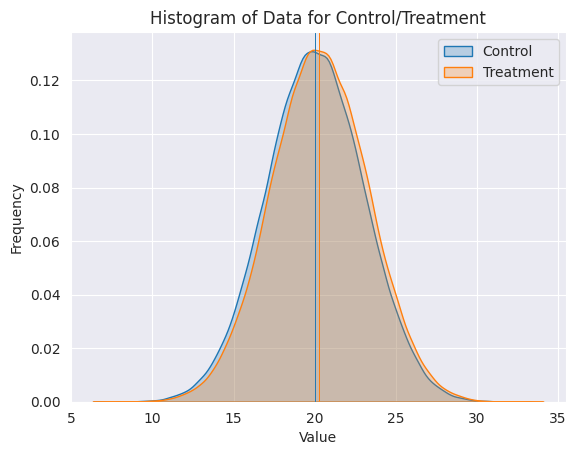

In [318]:
# Histogram of sampled data
sns.kdeplot(data_C, color = _colors[0], label = "Control", fill = True)
sns.kdeplot(data_T, color = _colors[1], label = "Treatment", fill = True)
plt.axvline(x = true_mean_C, color = _colors[0], linewidth = 0.7, linestyle = "-")
plt.axvline(x = true_mean_T, color = _colors[1], linewidth = 0.7, linestyle = "-")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment')
plt.legend()
plt.show()

---
# Part 2: Specify Priors

Assume Conjugate normal priors with distinct means and variances

In [319]:
# Control
delta_h0 = 0
sigma_h0 = 5

# Treatment
delta_h1 = 0.5
sigma_h1 = 5

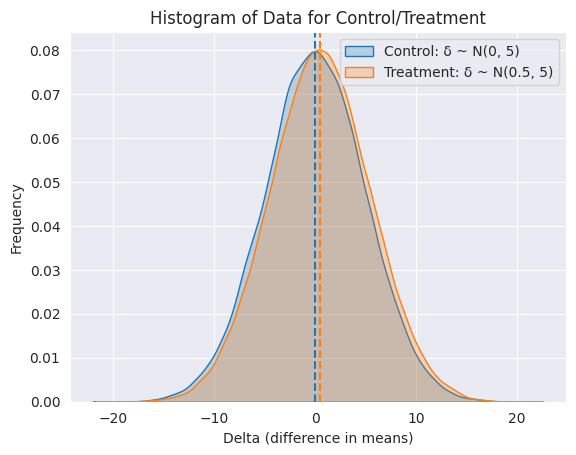

In [320]:
# Sample from prior distribution
prior_samples_control = np.random.normal(delta_h0, sigma_h0, 100000)
prior_samples_treatment = np.random.normal(delta_h1, sigma_h1, 100000)

# Histogram of sampled data
sns.kdeplot(prior_samples_control, fill = True, label = f'Control: δ ~ N({delta_h0}, {sigma_h0})')
sns.kdeplot(prior_samples_treatment, fill = True, label = f'Treatment: δ ~ N({delta_h1}, {sigma_h1})')
plt.axvline(x = delta_h0, color = _colors[0], linestyle = "--")
plt.axvline(x = delta_h1, color = _colors[1], linestyle = "--")
plt.xlabel('Delta (difference in means)')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment')
plt.legend()
plt.show()

---
# Part 3: Bayes factor

Marginal likelihood ratio with the following hypotheses:

$$ \mathbf{H_0}: \delta \leq 0 \qquad\quad \mathbf{H_1}: \delta > 0 $$


Following an implementation of Deng et Al (2016), in Wan et al (2023), the following bayes factor calculation is used:

$\mu'$ is calculated as $\frac{y\sigma_i^2 + \mu_i\sigma^2}{\sigma_i^2 + \sigma^2}$
and $\sigma_i'$ as $\sqrt{\frac{1}{\sigma^2 + \sigma_i^2}}$ for $i \in \{0, 1\}$.



The exact Bayes Factor for one-sided test is:

$$
\text{BF}[H_1 : H_0] = \frac{P(y|H_1)}{P(y|H_0)}
= \frac{ \int_{\mu>0} p(y|\mu)p(\mu|H_1)d\mu}{ \int_{\mu<0} p(y|\mu)p(\mu|H_0)d\mu}
$$

$$
= \frac{1 - \Phi(-\mu_1'/\sigma_1')}{1 - \Phi(-\mu_1/\sigma_1)} \times \frac{\Phi(-\mu_0/\sigma_0)}{\Phi(-\mu_0'/\sigma_0')} \times \sqrt{\frac{\sigma_0^2 + \sigma^2}{\sigma_1^2 + \sigma^2}} \times \exp\left(\frac{-1}{2}\left(\frac{(\mu_1 - y)^2}{\sigma^2 + \sigma_1^2}\right) + \frac{1}{2}\left(\frac{(\mu_0 - y)^2}{\sigma^2 + \sigma_0^2}\right)\right)
$$



In [321]:
import numpy as np
from scipy.stats import norm

def phi(x):
    """Cumulative distribution function for standard normal distribution."""
    return norm.cdf(x)

def bayes_factor(y, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma):
    """Compute the Bayes Factor given the data and hypotheses."""

    # Compute shared terms
    delta_0_prime = (y * sigma_h0**2 + delta_h0 * sigma**2) / (sigma_h0**2 + sigma**2)
    delta_1_prime = (y * sigma_h1**2 + delta_h1 * sigma**2) / (sigma_h1**2 + sigma**2)
    sigma_0_prime = np.sqrt(1 / (sigma**2 + sigma_h0**2))
    sigma_1_prime = np.sqrt(1 / (sigma**2 + sigma_h1**2))

    # Marginal likelihood under H0
    p_y_h0 = 1 - phi(-delta_1_prime / sigma_1_prime)

    # Marginal likelihood under H1
    p_y_h1 = 1 - phi(-delta_h1 / sigma_h1)

    # Ratio of normalizing constants
    normalizing_ratio = (phi(-delta_h0 / sigma_h0) / phi(-delta_0_prime / sigma_0_prime))

    # Variance ratio
    variance_ratio = np.sqrt((sigma_h0**2 + sigma**2) / (sigma_h1**2 + sigma**2))

    # Exponential term
    exp_term = np.exp(((-1 * (delta_h1 - y)**2) / (2*(sigma**2 + sigma_h1**2))) + ((1 * (delta_h0 - y)**2) / (2*(sigma**2 + sigma_h0**2))))

    # Compute Bayes Factor
    BF = (p_y_h1 / p_y_h0) * normalizing_ratio * variance_ratio * exp_term

    return BF

In [322]:
import numpy as np
from scipy.stats import norm

def phi(x):
    """Cumulative distribution function for the standard normal distribution."""
    return norm.cdf(x)

def bayes_factor2(y, mu_h0, sigma_h0, mu_h1, sigma_h1, sigma):
    """Compute the Bayes Factor given the data and hypotheses."""

    # Compute mu_prime and sigma_prime for H0 and H1
    mu_0_prime = (y * sigma_h0**2 + mu_h0 * sigma**2) / (sigma_h0**2 + sigma**2)
    mu_1_prime = (y * sigma_h1**2 + mu_h1 * sigma**2) / (sigma_h1**2 + sigma**2)
    sigma_0_prime = np.sqrt(1 / (sigma**2 + sigma_h0**2))
    sigma_1_prime = np.sqrt(1 / (sigma**2 + sigma_h1**2))

    # Marginal likelihood under H0, adjusted for mu_0_prime
    p_y_h0 = 1 - phi(-mu_0_prime / sigma_0_prime)

    # Marginal likelihood under H1, adjusted for mu_1_prime
    p_y_h1 = 1 - phi(-mu_1_prime / sigma_1_prime)

    # Ratio of normalizing constants, adjusted for mu_prime and mu
    normalizing_ratio = (phi(-mu_h0 / sigma_h0) / phi(-mu_0_prime / sigma_0_prime)) * \
                        ((1 - phi(-mu_1_prime / sigma_1_prime)) / (1 - phi(-mu_h1 / sigma_h1)))

    # Variance ratio
    variance_ratio = np.sqrt((sigma_h0**2 + sigma**2) / (sigma_h1**2 + sigma**2))

    # Exponential term
    exp_term = np.exp(((-1 * (mu_h1 - y)**2) / (2*(sigma**2 + sigma_h1**2))) + \
                      ((mu_h0 - y)**2) / (2*(sigma**2 + sigma_h0**2)))

    # Compute Bayes Factor
    BF = (p_y_h1 / p_y_h0) * normalizing_ratio * variance_ratio * exp_term

    return BF

In [323]:
# Bayes factor
print("Bayes Factor:", bayes_factor(delta, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma))

# Source data
print(f"""
Overview of Variables:
----------------------

Data:
- Observed difference (y): {delta}
- Standard deviation of observed data (sigma): {sigma}

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): {delta_h0}
- Standard deviation (sigma_h0): {sigma_h0}

Alternative Hypothesis (H1):
- Mean difference (delta_h1): {delta_h1}
- Standard deviation (sigma_h1): {sigma_h1}
""")

Bayes Factor: 3.778987914333534

Overview of Variables:
----------------------

Data:
- Observed difference (y): 0.2844500517094488
- Standard deviation of observed data (sigma): 0.00018020441054783948

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): 0
- Standard deviation (sigma_h0): 5

Alternative Hypothesis (H1):
- Mean difference (delta_h1): 0.5
- Standard deviation (sigma_h1): 5



## Early stopping

In [324]:
# Settings
k = 30
interim_test_interval = 5
print_es_progress = False # Print progress

# Initialise
bf, n_observed = 0, 10 # first n_observed is kind of cold start n
interim_tests = []


while n_observed <= N:
    # Get delta & sigma (given n_observed)
    delta_n = data_T[:n_observed].mean() - data_C[:n_observed].mean()
    sigma_n = data_C[:n_observed].var()/n_observed + data_T[:n_observed].var()/n_observed
    sigma_n = np.sqrt(sigma_n)

    # Get & store (beta) Bayes Factor
    bf = bayes_factor2(delta_n, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma_n)
    interim_tests.append((n_observed, bf))

    # option to print progress if desired
    if print_es_progress == True:
        print(f"n: {n_observed}/{N}, BF: {bayes_factor}")

    # # Stopping criteria
    # if (bf > k or bf < 1/k):
    #     break

    # Extend sample & get conversions
    n_observed += interim_test_interval

<ipython-input-322-55a89c030dcd>:35: RuntimeWarning: invalid value encountered in double_scalars
  BF = (p_y_h1 / p_y_h0) * normalizing_ratio * variance_ratio * exp_term


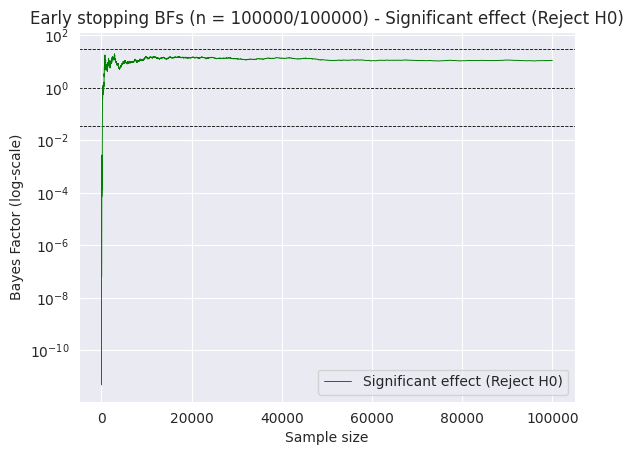


Overview of Variables:
----------------------

Fixed Horizon (n = 100000):
- Observed difference: 0.2844500517094488
- Standard deviation:  0.00018020441054783948

Fixed Horizon (n = 100005):
- Observed difference: 0.2844500517094488
- Standard deviation:  0.01342402363480635
- Bayes factor: 11.036147075386394

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): 0
- Standard deviation (sigma_h0): 5

Alternative Hypothesis (H1):
- Mean difference (delta_h1): 0.5
- Standard deviation (sigma_h1): 5



In [325]:
def plot_early_stopping(interim_tests):
    # plot stopping criteria
    plt.axhline(y = 1, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = k, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = 1/k, color = "black", linestyle = "--", linewidth = "0.6")

    # Plot interim testing Bayes-Factor development
    if interim_tests[-1][1] > 1: # Reject H0 (Effect discovery)
        color_i = "green"
        conclusion = "Significant effect (Reject H0)"
    else: # Accept H0 (No effect)
        color_i = "red"
        conclusion = "No effect (Accept H0)"

    x, y = zip(*interim_tests)
    plt.plot(x, y, linestyle = "-", linewidth = 0.7, color = color_i, label = conclusion)

    # Set the y-axis to log scale
    plt.yscale('log')
    plt.xlabel("Sample size")
    plt.ylabel("Bayes Factor (log-scale)")
    plt.legend()
    plt.title(f"Early stopping BFs (n = {interim_tests[-1][0]}/{N}) - {conclusion}")
    plt.show()

plot_early_stopping(interim_tests)

# Source data
print(f"""
Overview of Variables:
----------------------

Fixed Horizon (n = {N}):
- Observed difference: {delta}
- Standard deviation:  {sigma}

Fixed Horizon (n = {n_observed}):
- Observed difference: {delta_n}
- Standard deviation:  {sigma_n}
- Bayes factor: {bf}

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): {delta_h0}
- Standard deviation (sigma_h0): {sigma_h0}

Alternative Hypothesis (H1):
- Mean difference (delta_h1): {delta_h1}
- Standard deviation (sigma_h1): {sigma_h1}
""")